In [1]:
from scipy.stats import unitary_group
import numpy.random as rnd

In [2]:
def random_state(N, seed):
    """Create a random state on N qubits."""
    states = unitary_group.rvs(2 ** N, random_state=rnd.default_rng(seed))
    return states[0]


def random_observable(N, seed):
    """Create a random observable on N qubits."""
    rnd.seed(seed)
    # Generate real and imaginary part separately and (anti-)symmetrize them for Hermiticity
    real_part, imag_part = rnd.random((2, 2 ** N, 2 ** N))
    real_part += real_part.T
    imag_part -= imag_part.T
    return real_part + 1j * imag_part

In [3]:
random_state(3, 20)

array([-0.07062714-0.48404647j,  0.18552833+0.02837205j,
        0.18142108-0.07911353j,  0.07398692-0.36270572j,
        0.276394  -0.0056422j , -0.34970129-0.46823536j,
        0.12513347+0.07282229j, -0.13526774-0.30341945j])

In [3]:
from jax.config import config

config.update("jax_enable_x64", True)
# import jax
# from jax import numpy as np
import pennylane as qml
from pennylane import numpy as np

def make_cost(N, seed):
    """Create a cost function on N qubits with N frequencies."""
    dev = qml.device("default.qubit", wires=N)
    randobs = random_observable(N, seed)

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def cost(x):
        """Cost function on N qubits with N frequencies."""
        qml.QubitStateVector(random_state(N, seed), wires=dev.wires)
        for w in dev.wires:
            qml.RZ(x, wires=w, id="x")
#         qml.RZ(x, wires=0)
        return qml.expval(qml.PauliX(0))

    return cost

In [5]:
import matplotlib.pyplot as plt

# Set a plotting range on the x-axis
xlim = (-np.pi, np.pi)
X = np.linspace(*xlim, 60)
# Colors
green = "#209494"
orange = "#ED7D31"
red = "xkcd:brick red"
blue = "xkcd:cerulean"
pink = "xkcd:bright pink"

In [6]:
# Qubit numbers
Ns = [1, 2, 4, 5]
# Fix a seed
seed = 7658741

cost_functions = []
evaluated_cost = []
for N in Ns:
    # Generate the cost function for N qubits and evaluate it
    cost = make_cost(N, seed)
    evaluated_cost.append([cost(x) for x in X])
    cost_functions.append(cost)
    break

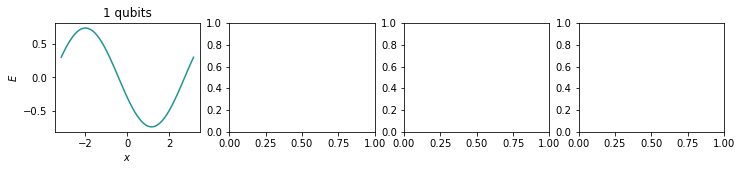

In [7]:
# Figure with multiple axes
fig, axs = plt.subplots(1, len(Ns), figsize=(12, 2))

for ax, N, E in zip(axs, Ns, evaluated_cost):
    # Plot cost function evaluations
    ax.plot(X, E, color=green)
    # Axis and plot labels
    ax.set_title(f"{N} qubits")
    ax.set_xlabel("$x$")

_ = axs[0].set_ylabel("$E$")
plt.show()

In [8]:
from pennylane.fourier import qnode_spectrum

spectra = []
for N, cost_function in zip(Ns, cost_functions):
    # Compute spectrum with respect to parameter x
    spec = qnode_spectrum(cost_function.__wrapped__)(X[0])["x"][()]
    print(f"For {N} qubits the spectrum is {spec}.")
    # Store spectrum
    spectra.append([freq for freq in spec if freq>0.0])

For 1 qubits the spectrum is [-1.0, 0.0, 1.0].


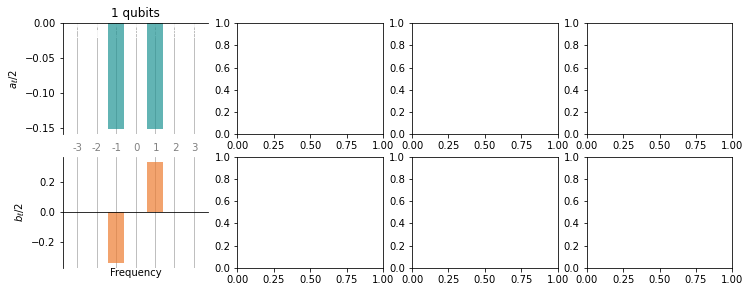

In [9]:
from pennylane.fourier.visualize import bar

fig, axs = plt.subplots(2, len(Ns), figsize=(12, 4.5))
for i, (cost_function, spec) in enumerate(zip(cost_functions, spectra)):
    # Compute the Fourier coefficients
    coeffs = qml.fourier.coefficients(cost_function, 1, len(spec)+2, lowpass_filter=True)
    # Show the Fourier coefficients
    bar(coeffs, 1, axs[:, i], show_freqs=True, colour_dict={"real": green, "imag": orange})
    axs[0, i].set_title(f"{Ns[i]} qubits")
    # Set x-axis labels
    axs[1, i].text(Ns[i] + 2, axs[1, i].get_ylim()[0], f"Frequency", ha="center", va="top")
    # Clean up y-axis labels
    if i == 0:
        _ = [axs[j, i].set_ylabel(lab) for j, lab in enumerate(["$a_\ell/2$", "$b_\ell/2$"])]
    else:
        _ = [axs[j, i].set_ylabel("") for j in [0, 1]]
plt.show()

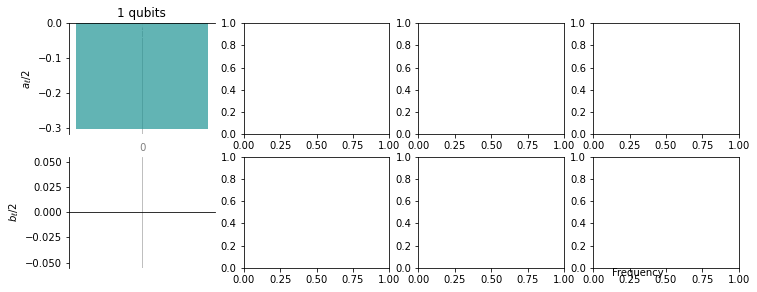

In [10]:
from pennylane.fourier.visualize import bar

fig, axs = plt.subplots(2, len(Ns), figsize=(12, 4.5))
for i, (cost_function, spec) in enumerate(zip(cost_functions, spectra)):
    # Compute the Fourier coefficients
    coeffs = qml.fourier.coefficients(cost_function, 1, len(spec)-1, lowpass_filter=True)
    # Show the Fourier coefficients
    bar(coeffs, 1, axs[:, i], show_freqs=True, colour_dict={"real": green, "imag": orange})
    axs[0, i].set_title(f"{Ns[i]} qubits")
    # Set x-axis labels
    axs[1, i].text(Ns[i] + 2, axs[1, i].get_ylim()[0], f"Frequency", ha="center", va="top")
    # Clean up y-axis labels
    if i == 0:
        _ = [axs[j, i].set_ylabel(lab) for j, lab in enumerate(["$a_\ell/2$", "$b_\ell/2$"])]
    else:
        _ = [axs[j, i].set_ylabel("") for j in [0, 1]]
plt.show()

In [11]:
sinc = lambda x: np.sinc(x / np.pi)

def full_reconstruction_equ(fun, R):
    """Reconstruct a univariate function with up to R frequencies using equidistant shifts."""
    # Shift angles for the reconstruction
    shifts = [2 * mu * np.pi / (2 * R + 1) for mu in range(-R, R + 1)]
    # Shifted function evaluations
    evals = np.array([fun(shift) for shift in shifts])

    @jax.jit
    def reconstruction(x):
        """Univariate reconstruction using equidistant shifts."""
        kernels = np.array(
            [sinc((R + 0.5) * (x - shift)) / sinc(0.5 * (x - shift)) for shift in shifts]
        )
        return np.dot(evals, kernels)

    return reconstruction

reconstructions_equ = list(map(full_reconstruction_equ, cost_functions, Ns))

TypeError: 'AxesSubplot' object is not subscriptable

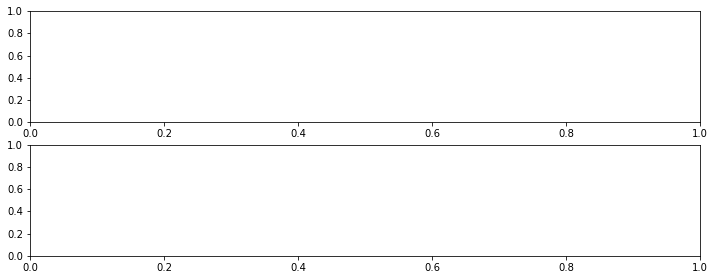

In [12]:
def compare_functions(originals, reconstructions, Ns, shifts, show_diff=True):
    """Plot two sets of functions next to each other and show their difference (in pairs)."""
    # Prepare the axes; we need fewer axes if we don't show the deviations
    if show_diff:
        fig, axs = plt.subplots(2, len(originals), figsize=(12, 4.5))
    else:
        fig, axs = plt.subplots(1, len(originals), figsize=(12, 2))
    _axs = axs[0] if show_diff else axs

    # Run over the functions and reconstructions
    for i, (orig, recon, N, _shifts) in enumerate(zip(originals, reconstructions, Ns, shifts)):
        # Evaluate the original function and its reconstruction over the plotting range
        E = np.array(list(map(orig, X)))
        E_rec = np.array(list(map(recon, X)))
        # Evaluate the original function at the positions used in the reconstruction
        E_shifts = np.array(list(map(orig, _shifts)))

        # Show E, the reconstruction, and the shifts (top axes)
        _axs[i].plot(X, E, lw=2, color=orange)
        _axs[i].plot(X, E_rec, linestyle=":", lw=3, color=green)
        _axs[i].plot(_shifts, E_shifts, ls="", marker="x", c=red)
        # Manage plot titles and xticks
        _axs[i].set_title(f"{N} qubits")

        if show_diff:
            # [Optional] Show the reconstruction deviation (bottom axes)
            axs[1, i].plot(X, E - E_rec, color=blue)
            axs[1, i].set_xlabel("$x$")
            # Hide the xticks of the top x-axes if we use the bottom axes
            _axs[i].set_xticks([])

    # Manage y-axis labels
    _ = _axs[0].set_ylabel("$E$")
    if show_diff:
        _ = axs[1, 0].set_ylabel("$E-E_{rec}$")

    return fig, axs

equ_shifts = [[2 * mu * np.pi / (2 * N + 1) for mu in range(-N, N + 1)] for N in Ns]
fig, axs = compare_functions(cost_functions, reconstructions_equ, Ns, equ_shifts)
plt.show()

In [ ]:
def full_reconstruction_gen(fun, shifts):
    """Reconstruct a univariate trigonometric function using arbitrary shifts."""
    R = (len(shifts) - 1) // 2
    frequencies = np.array(list(range(1, R + 1)))

    # Construct the matrix C case by case
    C1 = np.ones((2 * R + 1, 1))
    C2 = np.cos(np.outer(shifts, frequencies))
    C3 = np.sin(np.outer(shifts, frequencies))
    C = np.hstack([C1, C2, C3])

    # Evaluate the function to reconstruct at the shifted positions
    evals = np.array(list(map(fun, shifts)))

    # Solve the system of linear equations by inverting C
    W = np.linalg.inv(C) @ evals

    # Extract the Fourier coefficients
    a0 = W[0]
    a = W[1 : R + 1]
    b = W[R + 1 :]

    # Construct the Fourier series
    @jax.jit
    def reconstruction(x):
        """Univariate reconstruction based on arbitrary shifts."""
        return a0 + np.dot(a, np.cos(frequencies * x)) + np.dot(b, np.sin(frequencies * x))

    return reconstruction

In [ ]:
shifts = [rnd.random(2 * N + 1) * 2 * np.pi - np.pi for N in Ns]
reconstructions_gen = list(map(full_reconstruction_gen, cost_functions, shifts))
fig, axs = compare_functions(cost_functions, reconstructions_gen, Ns, shifts)
plt.show()

In [ ]:
shifts_odd = lambda R: [(2 * mu - 1) * np.pi / (2 * R) for mu in range(1, R + 1)]
# Odd linear combination of Dirichlet kernels
D_odd = lambda x, R: np.array(
    [
        (
            sinc(R * (x - shift)) / sinc(0.5 * (x - shift)) * np.cos(0.5 * (x - shift))
            - sinc(R * (x + shift)) / sinc(0.5 * (x + shift)) * np.cos(0.5 * (x + shift))
        )
        for shift in shifts_odd(R)
    ]
)


def odd_reconstruction_equ(fun, R):
    """Reconstruct the odd part of an ``R``-frequency input function via equidistant shifts."""
    evaluations = np.array([(fun(shift) - fun(-shift)) / 2 for shift in shifts_odd(R)])

    @jax.jit
    def reconstruction(x):
        """Odd reconstruction based on equidistant shifts."""
        return np.dot(evaluations, D_odd(x, R))

    return reconstruction


odd_reconstructions = list(map(odd_reconstruction_equ, cost_functions, Ns))

In [ ]:
shifts_even = lambda R: [mu * np.pi / R for mu in range(1, R)]
# Even linear combination of Dirichlet kernels
D_even = lambda x, R: np.array(
    [
        (
            sinc(R * (x - shift)) / sinc(0.5 * (x - shift)) * np.cos(0.5 * (x - shift))
            + sinc(R * (x + shift)) / sinc(0.5 * (x + shift)) * np.cos(0.5 * (x + shift))
        )
        for shift in shifts_even(R)
    ]
)
# Special cases of even kernels
D0 = lambda x, R: sinc(R * x) / (sinc(x / 2)) * np.cos(x / 2)
Dpi = lambda x, R: sinc(R * (x - np.pi)) / sinc((x - np.pi) / 2) * np.cos((x - np.pi) / 2)


def even_reconstruction_equ(fun, R):
    """Reconstruct the even part of ``R``-frequency input function via equidistant shifts."""
    _evaluations = np.array([(fun(shift) + fun(-shift)) / 2 for shift in shifts_even(R)])
    evaluations = np.array([fun(0), *_evaluations, fun(np.pi)])
    kernels = lambda x: np.array([D0(x, R), *D_even(x, R), Dpi(x, R)])

    @jax.jit
    def reconstruction(x):
        """Even reconstruction based on equidistant shifts."""
        return np.dot(evaluations, kernels(x))

    return reconstruction


even_reconstructions = list(map(even_reconstruction_equ, cost_functions, Ns))

In [ ]:
def summed_reconstruction_equ(fun, R):
    """Sum an odd and an even reconstruction into the full function."""
    _odd_part = odd_reconstruction_equ(fun, R)
    _even_part = even_reconstruction_equ(fun, R)

    def reconstruction(x):
        """Full function based on separate odd/even reconstructions."""
        return _odd_part(x) + _even_part(x)

    return reconstruction


summed_reconstructions = list(map(summed_reconstruction_equ, cost_functions, Ns))

In [ ]:
from matplotlib.lines import Line2D

# Obtain the shifts for the reconstruction of both parts
odd_and_even_shifts = [
    (
        shifts_odd(R)
        + shifts_even(R)
        + list(-1 * np.array(shifts_odd(R)))
        + list(-1 * np.array(shifts_odd(R)))
        + [0, np.pi]
    )
    for R in Ns
]

# Show the reconstructed parts and the sums
fig, axs = compare_functions(cost_functions, summed_reconstructions, Ns, odd_and_even_shifts)
for i, (odd_recon, even_recon) in enumerate(zip(odd_reconstructions, even_reconstructions)):
    # Odd part
    E_odd = np.array(list(map(odd_recon, X)))
    axs[0, i].plot(X, E_odd, color=red)
    # Even part
    E_even = np.array(list(map(even_recon, X)))
    axs[0, i].plot(X, E_even, color=blue)
    axs[0, i].set_title('')
_ = axs[1, 0].set_ylabel("$E-(E_{odd}+E_{even})$")
colors = [green, red, blue, orange]
styles = ['-', '-', '-', '--']
handles = [Line2D([0], [0], color=c, ls=ls, lw=1.2) for c, ls in zip(colors, styles)]
labels = ['Original', 'Odd reconstruction', 'Even reconstruction', 'Summed reconstruction']
_ = fig.legend(handles, labels, bbox_to_anchor=(0.2, 0.89), loc='lower left', ncol=4)
plt.show()

In [ ]:
# An iterative function computing the ``order``th derivative of a function ``f`` with JAX
grad_gen = lambda f, order: grad_gen(jax.grad(f), order - 1) if order > 0 else f

# Compute the first, second, and fourth derivative
for order, name in zip([1, 2, 4], ["First", "Second", "4th"]):
    recons = odd_reconstructions if order % 2 else even_reconstructions
    recon_name = "odd " if order % 2 else "even"
    cost_grads = np.array([grad_gen(orig, order)(0.0) for orig in cost_functions])
    recon_grads = np.array([grad_gen(recon, order)(0.0) for recon in recons])
    all_equal = (
        "All entries match" if np.allclose(cost_grads, recon_grads) else "Some entries differ!"
    )
    print(f"{name} derivatives via jax: {all_equal}")
    print("From the cost functions:       ", np.round(np.array(cost_grads), 6))
    print(f"From the {recon_name} reconstructions: ", np.round(np.array(recon_grads), 6), "\n")

In [ ]:
def parameter_shift_first(fun, R):
    """Compute the first-order derivative of a function with R frequencies at 0."""
    shifts = (2 * np.arange(1, 2 * R + 1) - 1) * np.pi / (4 * R)
    # Classically computed coefficients
    coeffs = np.array(
        [(-1) ** mu / (4 * R * np.sin(shift) ** 2) for mu, shift in enumerate(shifts)]
    )
    # Evaluations of the cost function E(x_mu)
    evaluations = np.array(list(map(fun, 2 * shifts)))
    # Contract coefficients with evaluations
    return np.dot(coeffs, evaluations)

ps_der1 = list(map(parameter_shift_first, cost_functions, Ns))

In [ ]:
def parameter_shift_second(fun, R):
    """Compute the second-order derivative of a function with R frequencies at 0."""
    shifts = np.arange(1, 2 * R) * np.pi / (2 * R)
    # Classically computed coefficients for the main sum
    _coeffs = [(-1) ** mu / (2 * np.sin(shift) ** 2) for mu, shift in enumerate(shifts)]
    # Include the coefficients for the "special" term E(0).
    coeffs = np.array([-(2 * R ** 2 + 1) / 6] + _coeffs)
    # Evaluate at the regularily shifted positions
    _evaluations = list(map(fun, 2 * shifts))
    # Include the "special" term E(0).
    evaluations = np.array([fun(0.0)] + _evaluations)
    # Contract coefficients with evaluations.
    return np.dot(coeffs, evaluations)

ps_der2 = list(map(parameter_shift_second, cost_functions, Ns))

In [ ]:
dx = 5e-5

def finite_diff_first(fun):
    """Compute the first order finite difference derivative."""
    return (fun(dx/2) - fun(-dx/2))/dx

fd_der1 = list(map(finite_diff_first, cost_functions))

def finite_diff_second(fun):
    """Compute the second order finite difference derivative."""
    fun_p, fun_0, fun_m = fun(dx), fun(0.0), fun(-dx)
    return ((fun_p - fun_0)/dx - (fun_0 - fun_m)/dx) /dx

fd_der2 = list(map(finite_diff_second, cost_functions))

In [ ]:
print("Number of qubits/RZ gates:         ", *Ns, sep=" " * 9)
print(f"First-order parameter-shift rule:  {np.round(np.array(ps_der1), 6)}")
print(f"First-order finite difference:     {np.round(np.array(fd_der1), 6)}")
print(f"Second-order parameter-shift rule: {np.round(np.array(ps_der2), 6)}")
print(f"Second-order finite difference:    {np.round(np.array(fd_der2), 6)}")

## Eigenvalues of Pauli Strings

In [ ]:
x = np.array([[0,1],[1,0]])
y = np.array([[0,-1j],[1j,0]])
z = np.array([[1,0],[0,-1]])
i = np.eye(2)

In [ ]:
np.linalg.eig(x)

In [ ]:
tpix = np.kron(np.kron(np.kron(i, z), i), i) + np.kron(np.kron(np.kron(x, i),i),i) - np.kron(np.kron(np.kron(i, i),y), i) - np.kron(np.kron(np.kron(x, z),y), x)
print(np.min(np.real(np.linalg.eig(tpix)[0])), np.max(np.real(np.linalg.eig(tpix)[0])))
print(np.sort(np.real(np.linalg.eig(tpix)[0])))

### prove that
- The eigenspectrum of commuting pauli words is symmetrically spaced out
- Use this fact to build the motivation for 2 term param shift rule as a good descent algorithm
- 

### 

### purity of a state

In [105]:
N = 3
dev = qml.device("default.qubit", wires=2*N)

@qml.qnode(dev)
def cost(params):
  
#   # first state
#   qml.RX(params[0], wires=0)
#   qml.RY(params[1], wires=1)
#   qml.RZ(params[2], wires=2)

#   # second state
#   qml.RX(params[0], wires=0)
#   qml.RY(params[1], wires=1)
#   qml.RZ(params[2], wires=2)

  for w in range(N):
    qml.CNOT(wires=[w, N+w])
    qml.Hadamard(wires=w)
  return qml.probs(wires=dev.wires)

In [106]:
params = np.random.random([3], requires_grad=True)

In [118]:
probs = cost(params)
print(len(probs))

64


In [108]:
def decimalToBinary(num, n):
    return np.array(list("{0:b}".format(int(num)).zfill(n)), requires_grad=False, dtype=np.int32)

def checkparity(r):
  o = r[0::2]
  p = r[1::2]
  logical_and = np.logical_and(o, p)
  return (np.sum(logical_and) % 2) == 1

def indxs_with_odd_parity(n):
  idxs = []
  d2bs = []
  n = 2*n
  num_states = 2**n
  for i in range(num_states):
    d2b = decimalToBinary(i, n)
    if checkparity(d2b):
      idxs.append(i)
      d2bs.append(d2b)
  return idxs, d2bs

In [109]:
print(checkparity(np.array([1,1,0,0])) == False)

False


In [110]:
idxs, d2bs = indxs_with_odd_parity(3)

In [111]:
decimalToBinary(64,7)

tensor([1, 0, 0, 0, 0, 0, 0], dtype=int32, requires_grad=False)

In [112]:
format(10, '08b')

'00001010'

In [113]:
idxs

[3,
 7,
 11,
 12,
 13,
 14,
 19,
 23,
 27,
 28,
 29,
 30,
 35,
 39,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 52,
 53,
 54,
 56,
 57,
 58,
 63]

In [114]:
checkparity([0, 0, 0, 0, 1, 1])

tensor(True, requires_grad=True)

In [115]:
d2bs

[tensor([0, 0, 0, 0, 1, 1], dtype=int32, requires_grad=False),
 tensor([0, 0, 0, 1, 1, 1], dtype=int32, requires_grad=False),
 tensor([0, 0, 1, 0, 1, 1], dtype=int32, requires_grad=False),
 tensor([0, 0, 1, 1, 0, 0], dtype=int32, requires_grad=False),
 tensor([0, 0, 1, 1, 0, 1], dtype=int32, requires_grad=False),
 tensor([0, 0, 1, 1, 1, 0], dtype=int32, requires_grad=False),
 tensor([0, 1, 0, 0, 1, 1], dtype=int32, requires_grad=False),
 tensor([0, 1, 0, 1, 1, 1], dtype=int32, requires_grad=False),
 tensor([0, 1, 1, 0, 1, 1], dtype=int32, requires_grad=False),
 tensor([0, 1, 1, 1, 0, 0], dtype=int32, requires_grad=False),
 tensor([0, 1, 1, 1, 0, 1], dtype=int32, requires_grad=False),
 tensor([0, 1, 1, 1, 1, 0], dtype=int32, requires_grad=False),
 tensor([1, 0, 0, 0, 1, 1], dtype=int32, requires_grad=False),
 tensor([1, 0, 0, 1, 1, 1], dtype=int32, requires_grad=False),
 tensor([1, 0, 1, 0, 1, 1], dtype=int32, requires_grad=False),
 tensor([1, 0, 1, 1, 0, 0], dtype=int32, requires_grad=

In [119]:
1 - 2*np.sum(np.array(probs)[idxs])

tensor(0.5, requires_grad=True)